In [6]:
#this notebook is dedicated to training a yolo detection model using the ultralytics library and eventually quantization
# reference vid: https://www.youtube.com/watch?v=r0RspiLG260

In [7]:
!nvidia-smi

Thu Dec 11 03:36:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [15]:
from google.colab import drive
drive.mount('/content/drive/')

!cp /content/drive/MyDrive/surfrider/data_ultralytics.zip /content
!unzip -q /content/data_ultralytics.zip -d /content/data

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [16]:
import os
import shutil
import random

def split_dataset(source_dir, train_dir, val_dir, split_ratio=0.8, seed=42):
    random.seed(seed)

    images_path = os.path.join(source_dir, 'images')
    labels_path = os.path.join(source_dir, 'labels')

    # Get list of all image files (assume .jpg or .png)
    image_files = [f for f in os.listdir(images_path) if f.endswith(('.jpg', '.png'))]
    random.shuffle(image_files)

    # Split indices
    split_idx = int(len(image_files) * split_ratio)
    train_files = image_files[:split_idx]
    val_files = image_files[split_idx:]

    # Ensure directories exist
    os.makedirs(os.path.join(train_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(train_dir, 'labels'), exist_ok=True)
    os.makedirs(os.path.join(val_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(val_dir, 'labels'), exist_ok=True)

    def copy_files(file_list, dest_dir):
        for img_file in file_list:
            # Copy image
            shutil.copy(os.path.join(images_path, img_file), os.path.join(dest_dir, 'images', img_file))

            # Copy corresponding label (same name, but .txt)
            label_file = os.path.splitext(img_file)[0] + '.txt'
            shutil.copy(os.path.join(labels_path, label_file), os.path.join(dest_dir, 'labels', label_file))

    copy_files(train_files, train_dir)
    copy_files(val_files, val_dir)

    print(f"Copied {len(train_files)} images to {train_dir} and {len(val_files)} images to {val_dir}")

split_dataset('/content/data/', '/content/data/train', '/content/data/validation')


Copied 3424 images to /content/data/train and 856 images to /content/data/validation


In [17]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.2 MB/s eta 0:00:00


In [18]:
import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Read class.txt to get class names
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Create data dictionary
  data = {
      'path': '/content/data',
      'train': 'train/images',
      'val': 'validation/images',
      'nc': number_of_classes,
      'names': classes
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = '/content/data/classes.txt'
path_to_data_yaml = '/content/data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
!cat /content/data.yaml

Created config file at /content/data.yaml

File contents:

path: /content/data
train: train/images
val: validation/images
nc: 10
names:
- Bottle-shaped
- Can-shaped
- Drum
- Easily namable
- Fishing net - cord
- Insulating material
- Other packaging
- Sheet - tarp - plastic bag - fragment
- Tire
- Unclear


In [21]:
from ultralytics import YOLO

# This auto-downloads yolo11n.pt if needed
model = YOLO('yolo11n.pt')

# Train it
results = model.train(
    data='/content/data.yaml',
    epochs=50,
    imgsz=640,
    batch=16
)

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretr

In [27]:
!yolo detect predict model=/content/runs/detect/train/weights/best.pt source=/content/data/validation/images save=True

Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,584,102 parameters, 0 gradients, 6.3 GFLOPs

image 1/856 /content/data/validation/images/001aaa70-130a-4074-84dc-804b4bb2c69d_jpg.rf.a8f2ff648485e2b59aa69f2f39861c47.jpg: 640x480 1 Sheet - tarp - plastic bag - fragment, 47.4ms
image 2/856 /content/data/validation/images/003bc77c-3562-403e-83d7-a2748124f5ad_jpg.rf.e55b66c85d8f9e1c6f194d2508fac107.jpg: 480x640 1 Sheet - tarp - plastic bag - fragment, 49.0ms
image 3/856 /content/data/validation/images/007141b1-454d-472f-8a6c-23a6f1a5a61f_jpg.rf.2bc0436f6053e3356bd11c7daaac63a2.jpg: 640x480 2 Sheet - tarp - plastic bag - fragments, 8.1ms
image 4/856 /content/data/validation/images/00831499-e198-420e-9e41-608512984dc6_jpg.rf.9964225a83199da44761a816572662f0.jpg: 640x480 2 Sheet - tarp - plastic bag - fragments, 7.6ms
image 5/856 /content/data/validation/images/009801bb-dee9-45b0-9fc6-3a394465bae7_jpg.rf.8f52c9e1f81da19c4

📸 Showing prediction results:


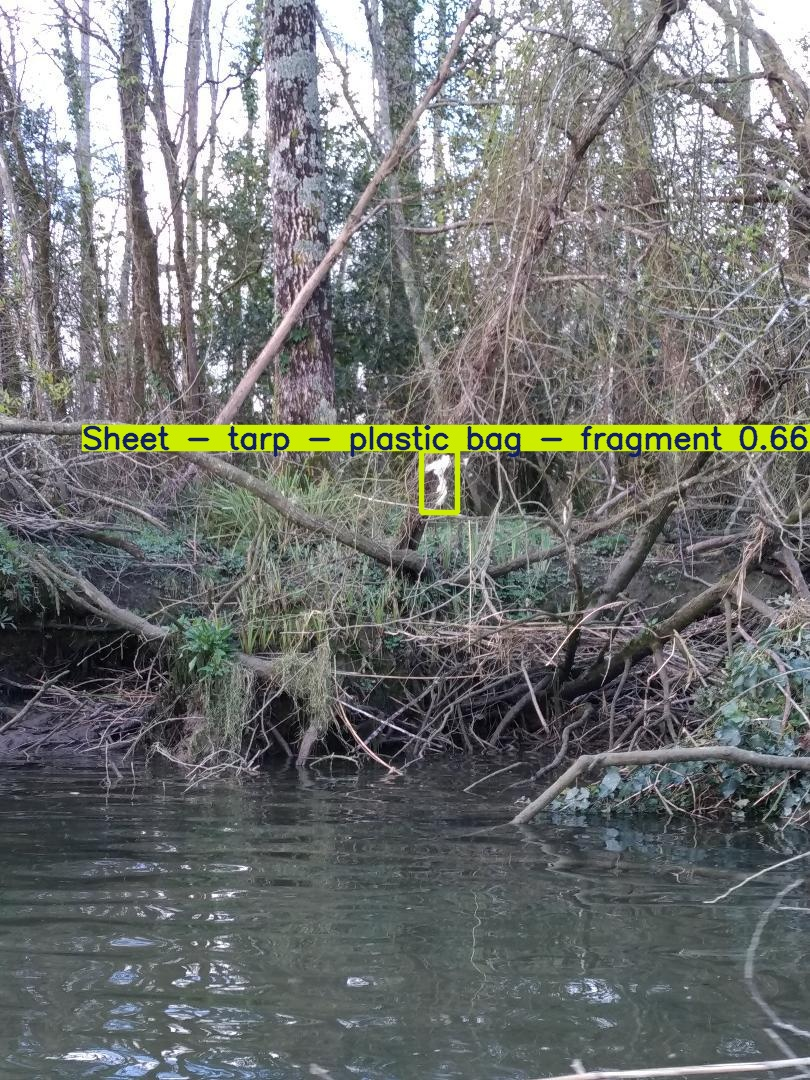

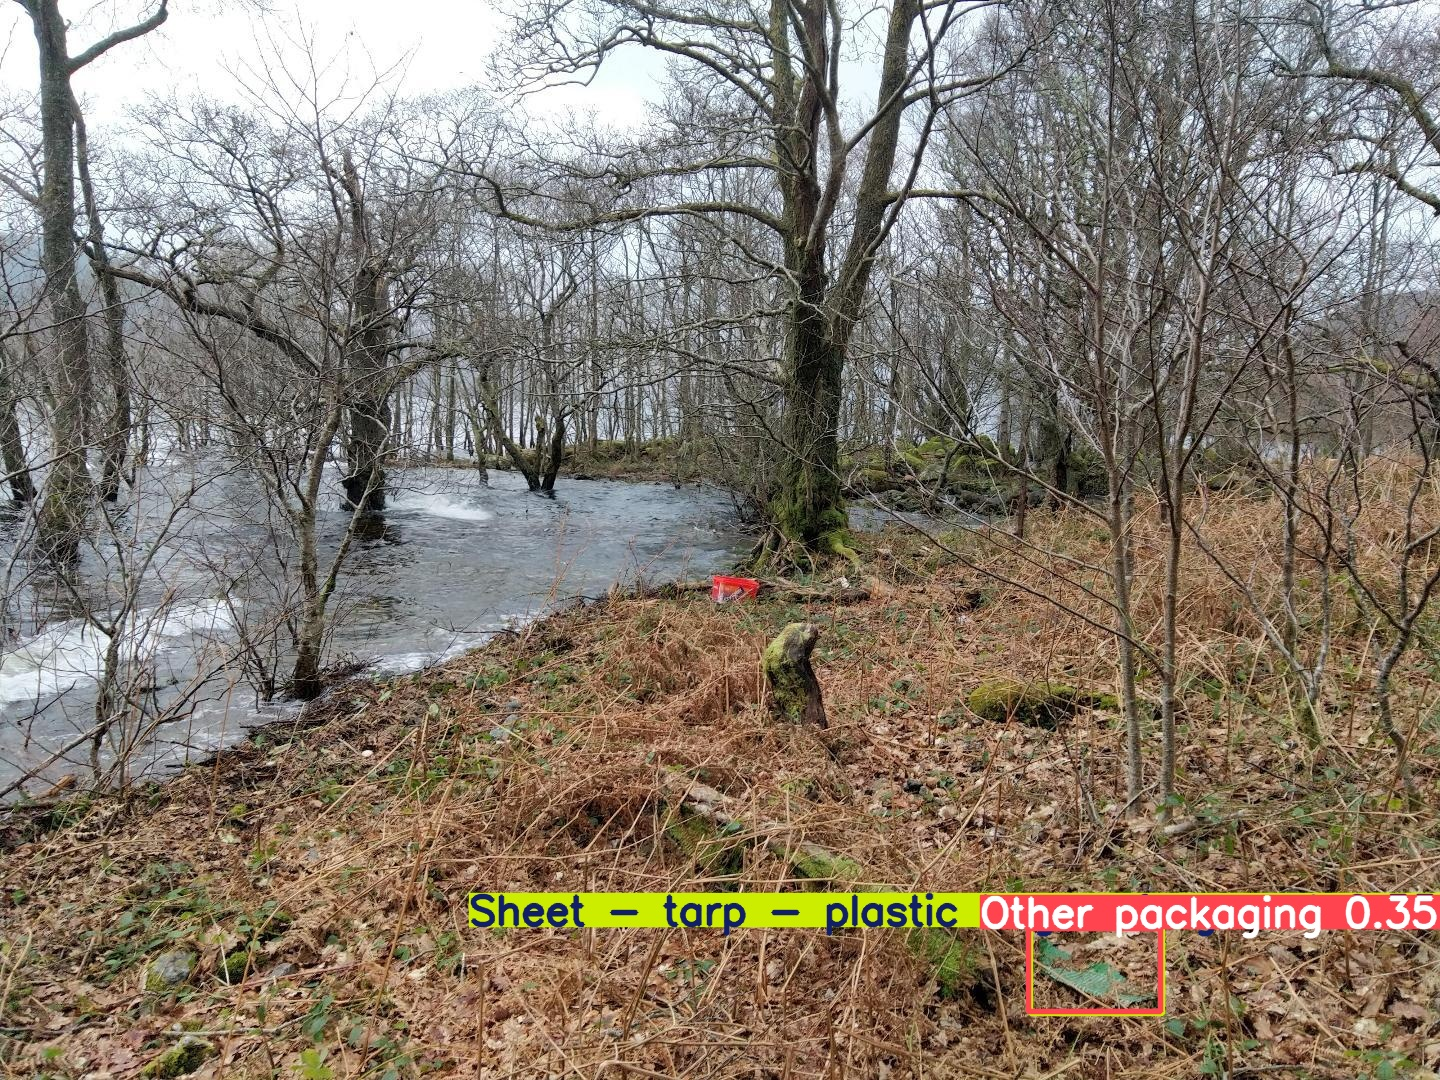

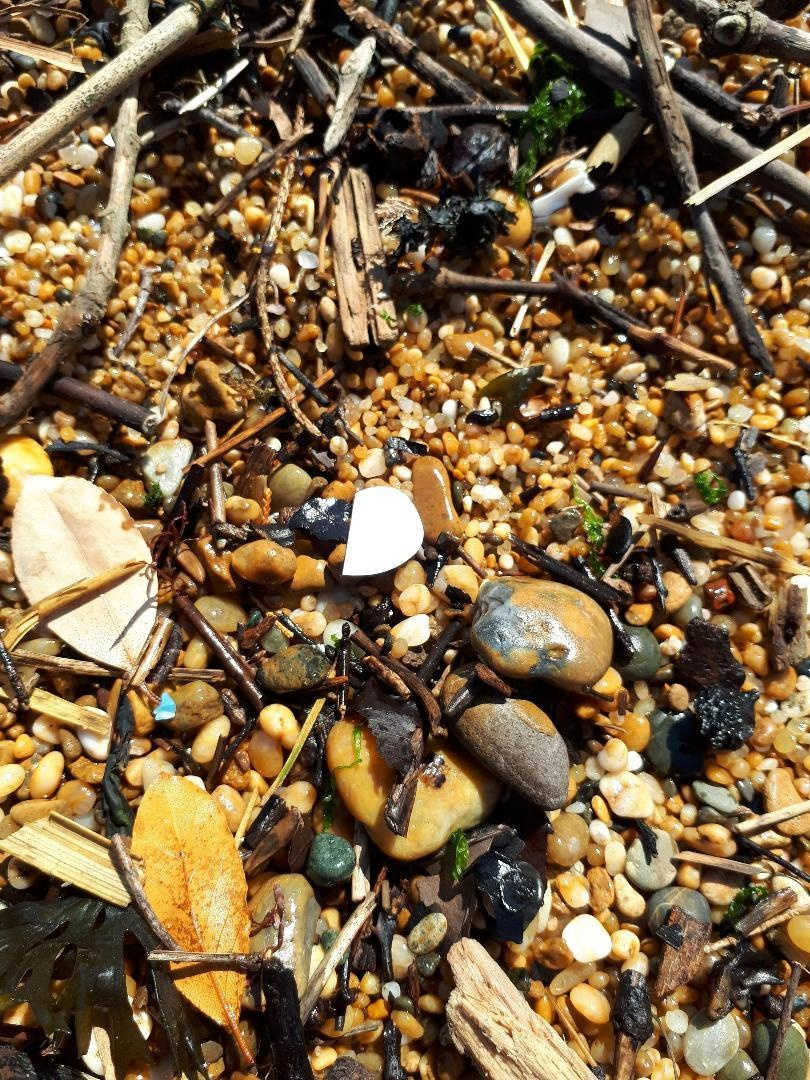

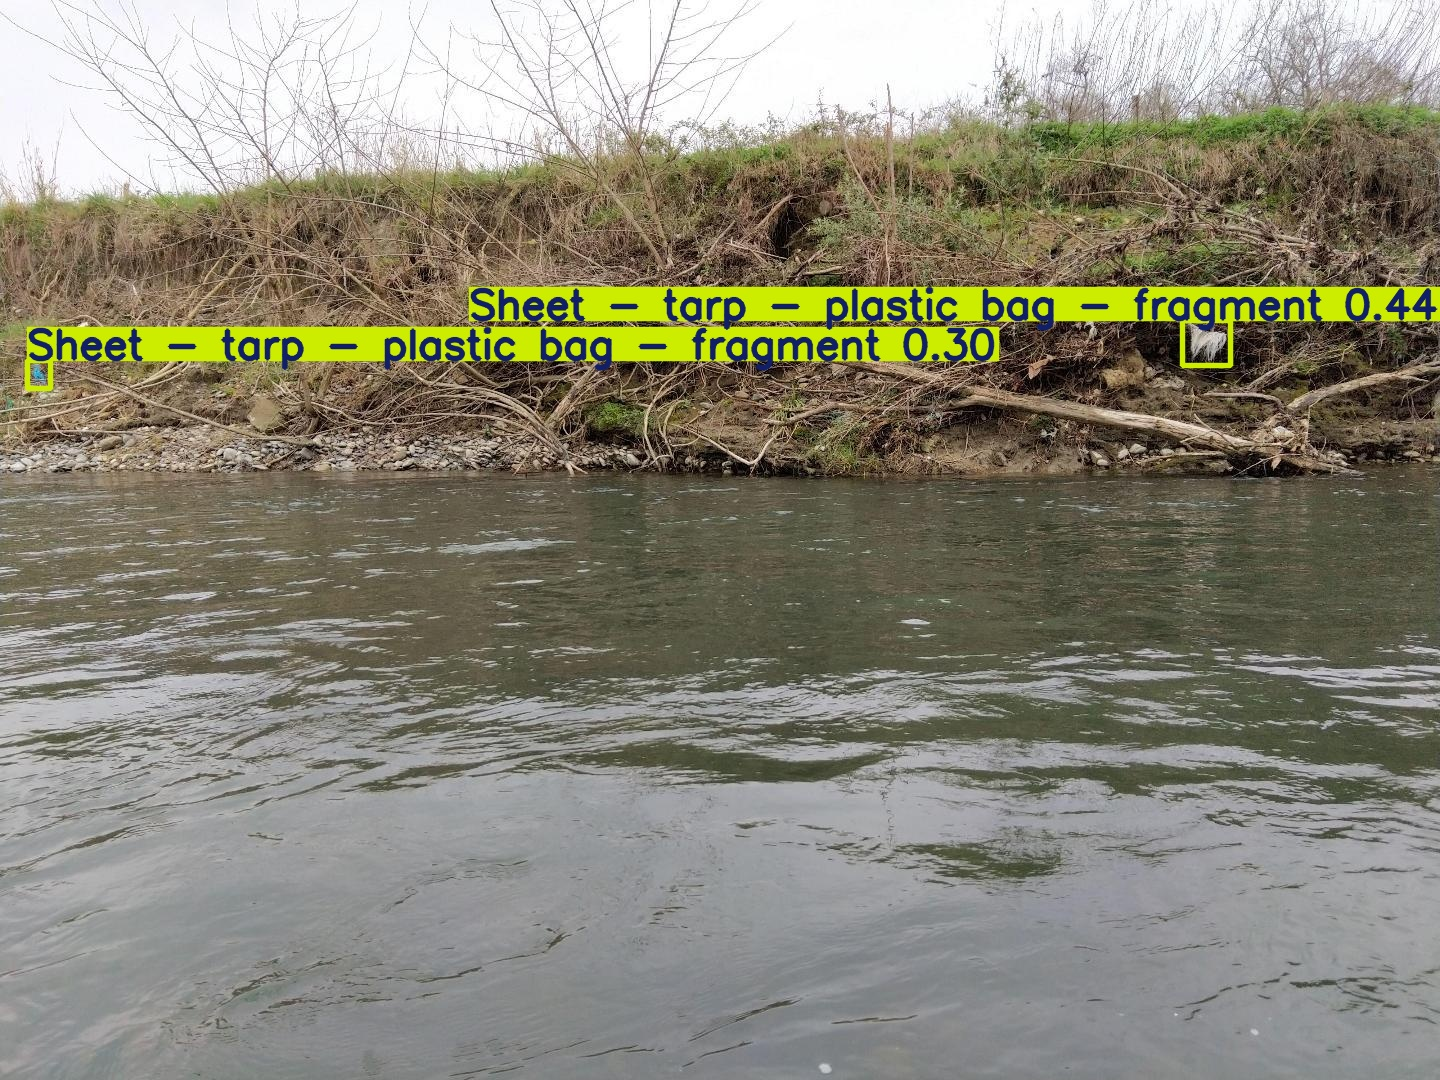

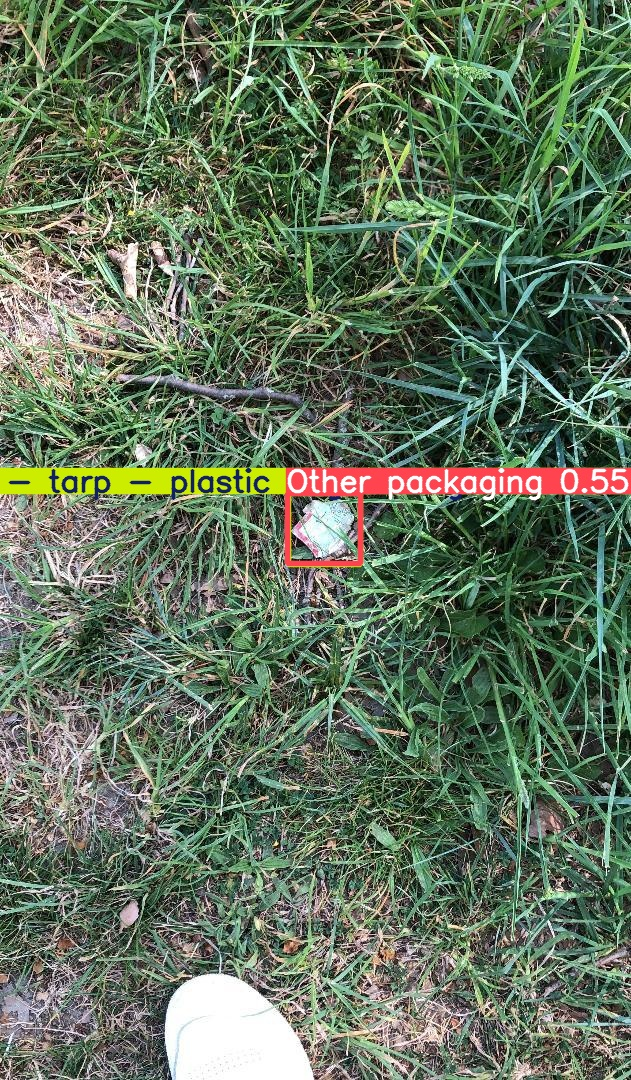

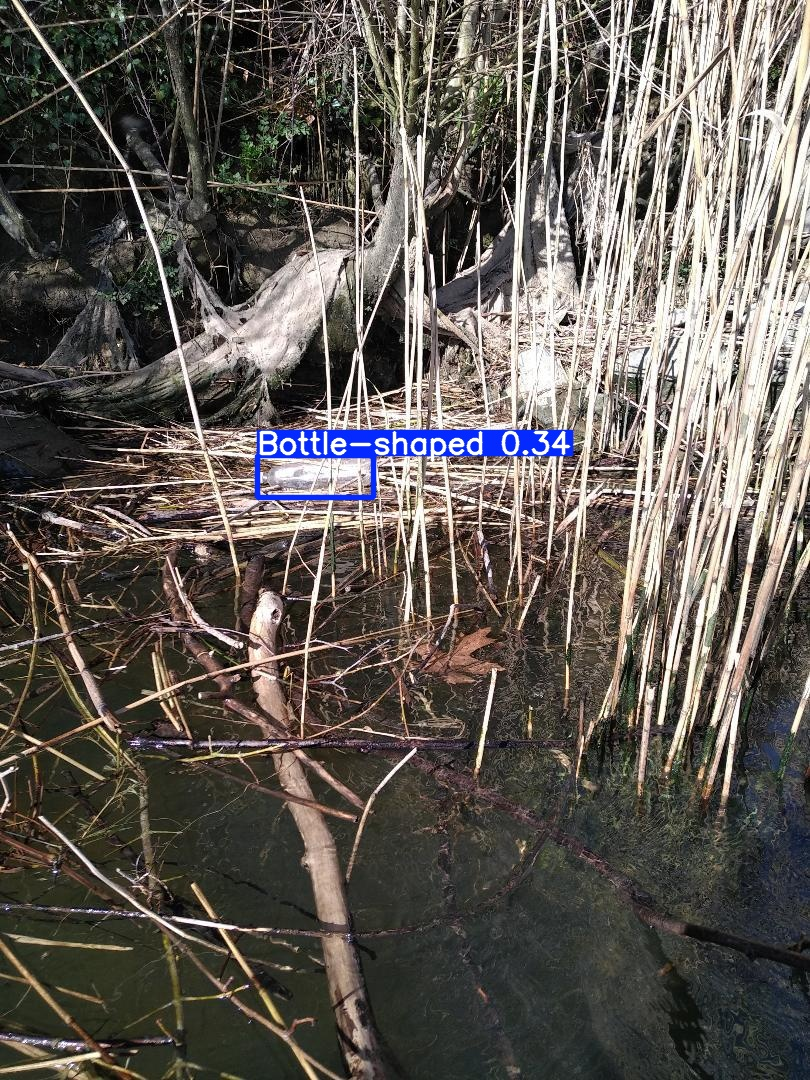

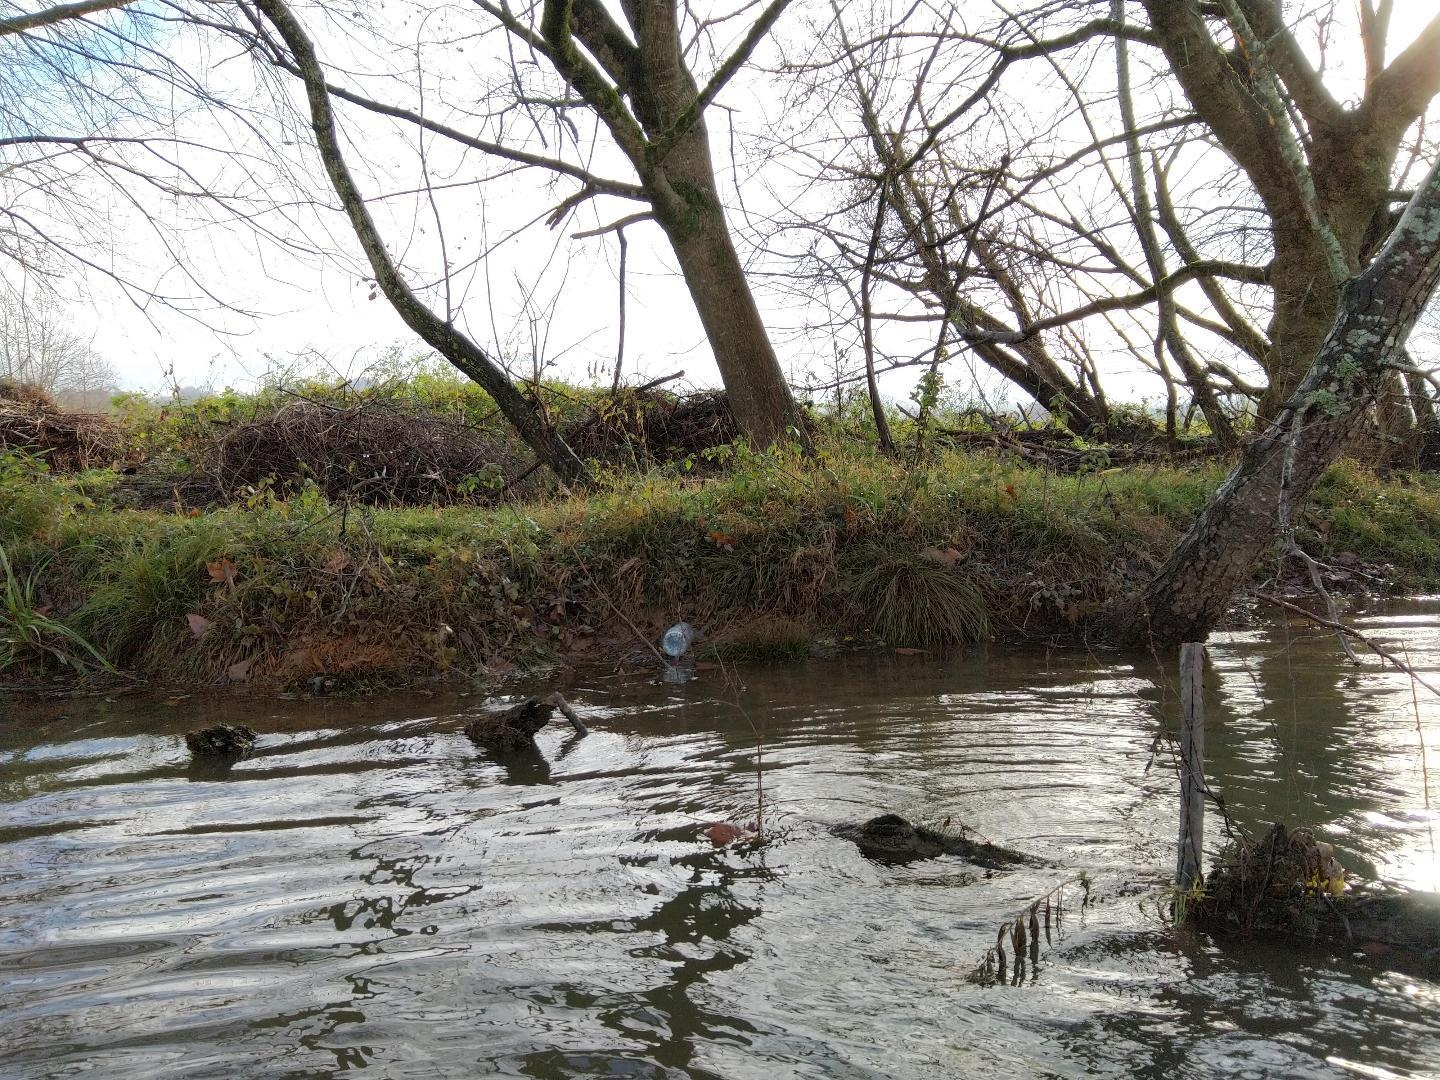

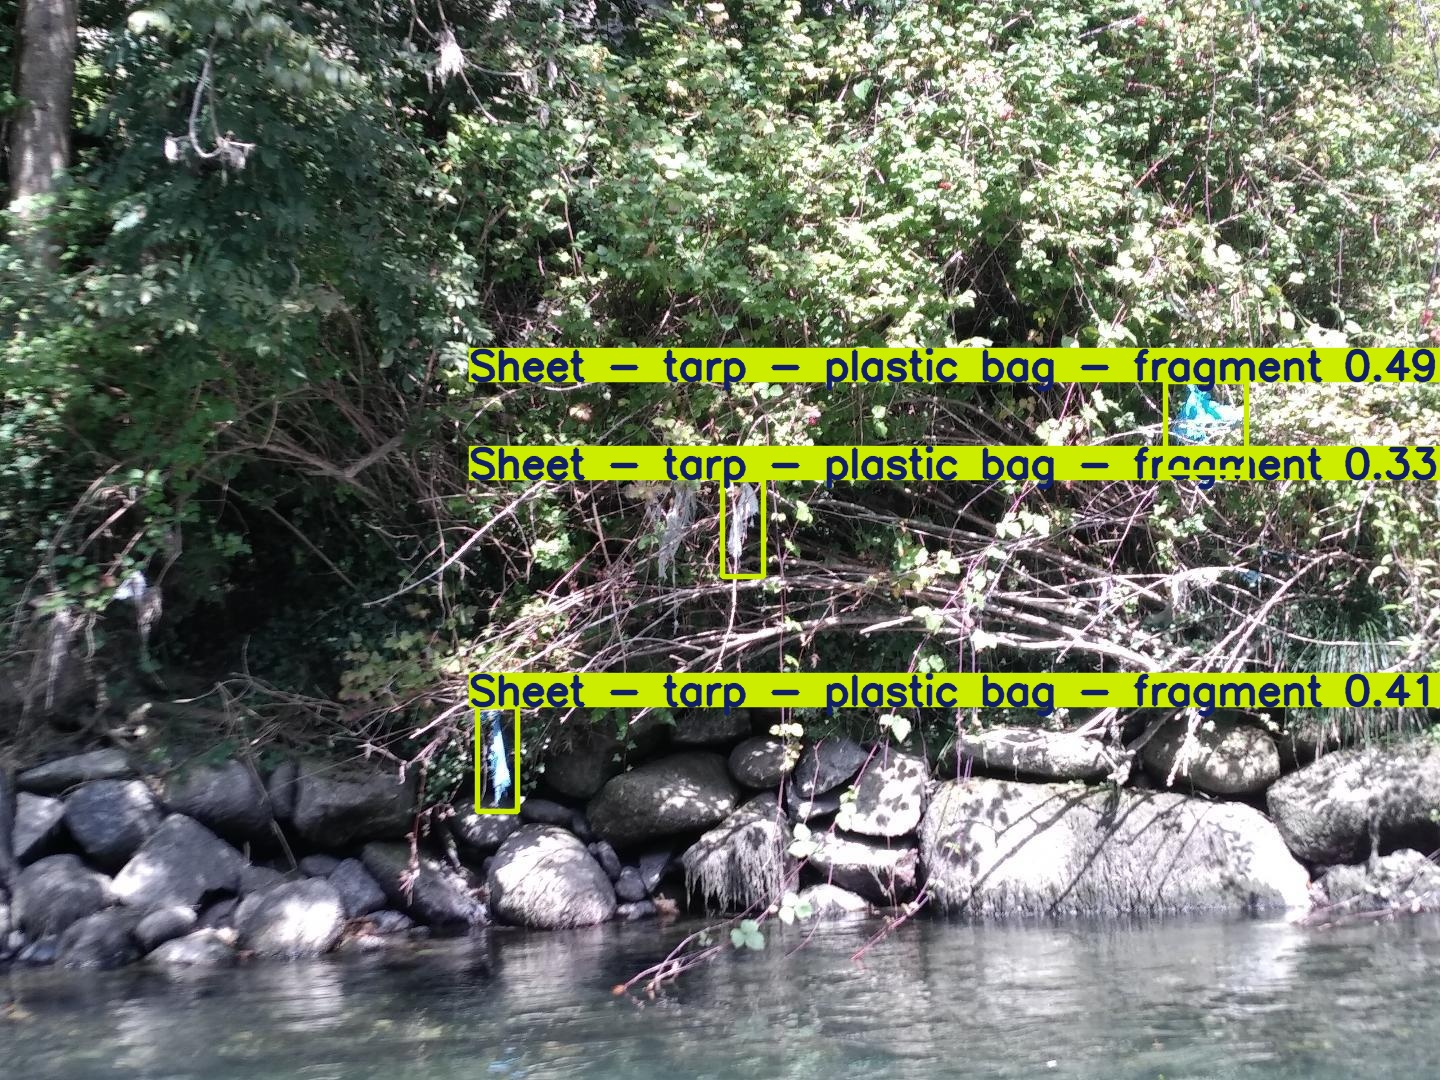

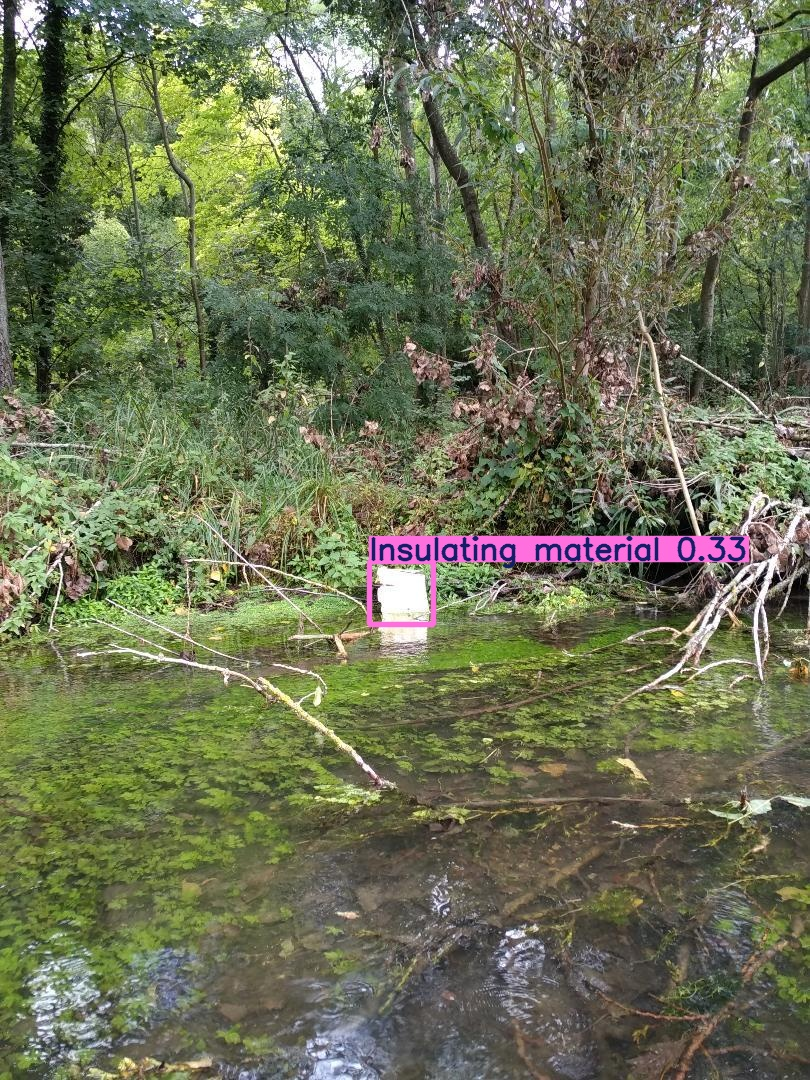

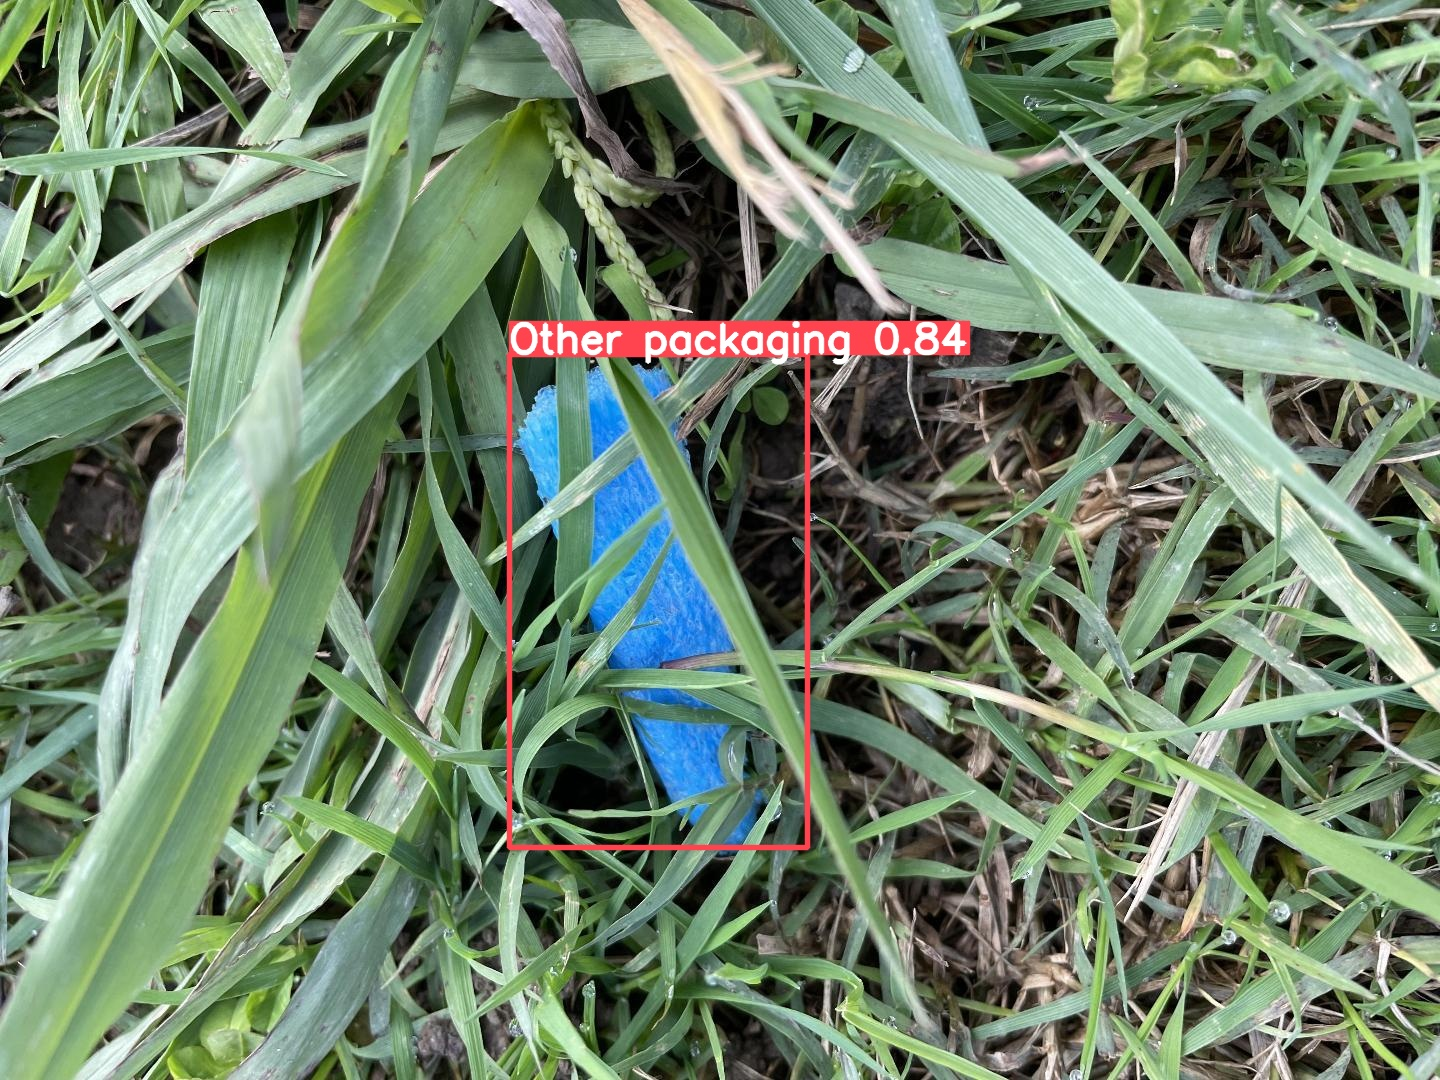

In [28]:
import glob
from IPython.display import Image, display

print("📸 Showing prediction results:")
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
    display(Image(filename=image_path, height=400))
    print('\n')

In [29]:
# Create "my_model" folder to store model weights and train results
!mkdir -p /content/my_model
!cp /content/runs/detect/train/weights/best.pt /content/my_model/my_model.pt
!cp -r /content/runs/detect/train /content/my_model

# Set path variables
MODEL_PT = "/content/my_model/my_model.pt"
MODEL_DIR = "/content/my_model"
DATA_YAML = "/content/data.yaml"

print(f"✅ Model copied to {MODEL_PT}")

✅ Model copied to /content/my_model/my_model.pt


# Optimization

Pruning

## Why We're Not Using Pruning

We attempted to apply structured L1 pruning to reduce model size, but it didn't work effectively with YOLO's architecture.

**What we tried:**
- Applied 20% structured pruning to 87 convolutional layers
- Fine-tuned for 10 epochs to recover accuracy

**Results:**
- Parameters: 2,591,790 → 2,591,790 (0.0% reduction ❌)
- File size: 5.20 MB → 5.23 MB (no reduction)
- Accuracy: 22.7% → 21.0% mAP50 (7.5% loss)
- Time spent: 15 minutes

**Why it failed:**
- YOLO has skip connections and concatenations throughout the architecture
- You can't remove channels from one layer without breaking connections to other layers
- Structured pruning marked weights as zero but couldn't actually remove them
- The model architecture constraints prevented real parameter reduction

**Conclusion:**
Pruning YOLO models requires custom architecture-aware pruning logic, which is complex and not worth the effort. INT8 quantization alone provides excellent compression (71.6% size reduction) with minimal accuracy loss (5.7%).

**Our final approach:**
- Train model → Export to ONNX → Apply INT8 quantization
- Result: 2.88 MB with 22.7% mAP50 ✅

Quantization

In [47]:
# Install onnxruntime and onnxruntime-tools for INT8 quantization
!pip install -q onnxruntime onnxruntime-tools

print("✅ Quantization tools installed")

✅ Quantization tools installed


In [48]:
from ultralytics import YOLO
from onnxruntime.quantization import quantize_dynamic, QuantType
import os

print("🔧 Starting ONNX export and quantization...\n")

# Step 1: Export to ONNX FP32
print("1️⃣ Exporting to FP32 ONNX format...")
model = YOLO(MODEL_PT)
exported = model.export(format='onnx', imgsz=640)

# Define paths
ONNX_FP32 = os.path.join(MODEL_DIR, "my_model.onnx")
ONNX_INT8 = os.path.join(MODEL_DIR, "my_model_quantized.onnx")

# Verify the FP32 ONNX file exists
if not os.path.exists(ONNX_FP32):
    print(f"❌ Error: ONNX file not found at {ONNX_FP32}")
else:
    print(f"✅ Found ONNX file: {ONNX_FP32}")

# Step 2: Apply INT8 quantization
print("\n2️⃣ Applying INT8 quantization...")
quantize_dynamic(
    model_input=ONNX_FP32,
    model_output=ONNX_INT8,
    weight_type=QuantType.QUInt8
)

# Step 3: Compare file sizes
fp32_size = os.path.getsize(ONNX_FP32) / (1024 * 1024)
int8_size = os.path.getsize(ONNX_INT8) / (1024 * 1024)
pt_size = os.path.getsize(MODEL_PT) / (1024 * 1024)

print(f"\n📦 Model Size Comparison:")
print(f"   Original PyTorch (.pt): {pt_size:.2f} MB")
print(f"   FP32 ONNX: {fp32_size:.2f} MB")
print(f"   INT8 ONNX (quantized): {int8_size:.2f} MB")
print(f"\n   📉 Size reduction from FP32: {((fp32_size - int8_size) / fp32_size * 100):.1f}%")
print(f"   📉 Size reduction from PyTorch: {((pt_size - int8_size) / pt_size * 100):.1f}%")
print(f"\n✅ Quantized model saved to: {ONNX_INT8}")

🔧 Starting ONNX export and quantization...

1️⃣ Exporting to FP32 ONNX format...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
YOLO11n summary (fused): 100 layers, 2,584,102 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from '/content/my_model/my_model.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 14, 8400) (5.2 MB)

ONNX: starting export with onnx 1.20.0 opset 22...
ONNX: slimming with onnxslim 0.1.78...
ONNX: export success ✅ 4.5s, saved as '/content/my_model/my_model.onnx' (10.1 MB)

Export complete (5.2s)
Results saved to /content/my_model
Predict:         yolo predict task=detect model=/content/my_model/my_model.onnx imgsz=640  
Validate:        yolo val task=detect model=/content/my_model/my_model.onnx imgsz=640 data=/content/data.yaml  
Visualize:       https://netron.app


✅ Found ONNX file: /content/my_model/my_model.onnx

2️⃣ Applying INT8 quantization...

📦 Model Size Comparison:
   Original PyTorch (.pt): 5.20 MB
   FP32 ONNX: 10.12 MB
   INT8 ONNX (quantized): 2.88 MB

   📉 Size reduction from FP32: 71.6%
   📉 Size reduction from PyTorch: 44.7%

✅ Quantized model saved to: /content/my_model/my_model_quantized.onnx


In [49]:
from ultralytics import YOLO

print("📊 Validating models...\n")

# Validate original PyTorch model
print("1️⃣ Validating original PyTorch model...")
model_pt = YOLO(MODEL_PT)
results_pt = model_pt.val(data=DATA_YAML)

# Validate FP32 ONNX model
print("\n2️⃣ Validating FP32 ONNX model...")
model_fp32 = YOLO(ONNX_FP32)
results_fp32 = model_fp32.val(data=DATA_YAML)

# Validate INT8 quantized model
print("\n3️⃣ Validating INT8 quantized model...")
model_int8 = YOLO(ONNX_INT8)
results_int8 = model_int8.val(data=DATA_YAML)

# Compare metrics
print("\n" + "="*60)
print("📈 ACCURACY COMPARISON")
print("="*60)
print(f"\nMetric          PyTorch    FP32 ONNX    INT8 ONNX")
print("-" * 60)
print(f"mAP50           {results_pt.results_dict['metrics/mAP50(B)']:.4f}     {results_fp32.results_dict['metrics/mAP50(B)']:.4f}       {results_int8.results_dict['metrics/mAP50(B)']:.4f}")
print(f"mAP50-95        {results_pt.results_dict['metrics/mAP50-95(B)']:.4f}     {results_fp32.results_dict['metrics/mAP50-95(B)']:.4f}       {results_int8.results_dict['metrics/mAP50-95(B)']:.4f}")
print(f"Precision       {results_pt.results_dict['metrics/precision(B)']:.4f}     {results_fp32.results_dict['metrics/precision(B)']:.4f}       {results_int8.results_dict['metrics/precision(B)']:.4f}")
print(f"Recall          {results_pt.results_dict['metrics/recall(B)']:.4f}     {results_fp32.results_dict['metrics/recall(B)']:.4f}       {results_int8.results_dict['metrics/recall(B)']:.4f}")
print("\n" + "="*60)

# Summary
accuracy_loss = (results_fp32.results_dict['metrics/mAP50(B)'] - results_int8.results_dict['metrics/mAP50(B)']) / results_fp32.results_dict['metrics/mAP50(B)'] * 100
print(f"\n💡 Summary: {((fp32_size - int8_size) / fp32_size * 100):.1f}% size reduction with {accuracy_loss:.1f}% accuracy loss")

📊 Validating models...

1️⃣ Validating original PyTorch model...
Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,584,102 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3183.5±1013.3 MB/s, size: 272.9 KB)
val: Scanning /content/data/validation/labels.cache... 856 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 856/856 1.7Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 54/54 4.2it/s 12.9s
                   all        856       1406      0.373      0.297      0.227      0.118
         Bottle-shaped        161        220      0.461      0.532      0.468      0.208
            Can-shaped         34         40      0.215        0.2       0.17     0.0829
                  Drum         13         14      0.291      0.214      0.155     0.0803
        Easily namable         34         39      0.245      0.308

In [50]:
print("📦 Packaging models...\n")

# Create comprehensive zip with models
%cd /content/my_model
!zip /content/my_model.zip my_model.pt my_model_quantized.onnx
!zip -r /content/my_model.zip train
%cd /content

# Copy to Google Drive
!cp /content/my_model.zip /content/drive/MyDrive/surfrider/

print("\n✅ All models saved to Google Drive!")
print("\n📦 Package includes:")
print("   - my_model.pt (Original YOLOv11n PyTorch - 5.20 MB)")
print("   - my_model_quantized.onnx (INT8 quantized - 2.88 MB) ⭐")
print("   - train/ (Training results, metrics, plots)")
print("\n🎯 Deploy my_model_quantized.onnx to Raspberry Pi!")

📦 Packaging models...

/content/my_model
  adding: my_model.pt (deflated 10%)
  adding: my_model_quantized.onnx (deflated 35%)
  adding: train/ (stored 0%)
  adding: train/train_batch1.jpg (deflated 2%)
  adding: train/val_batch1_pred.jpg (deflated 4%)
  adding: train/val_batch0_labels.jpg (deflated 5%)
  adding: train/confusion_matrix.png (deflated 18%)
  adding: train/results.png (deflated 7%)
  adding: train/val_batch1_labels.jpg (deflated 4%)
  adding: train/train_batch2.jpg (deflated 1%)
  adding: train/val_batch0_pred.jpg (deflated 5%)
  adding: train/train_batch8562.jpg (deflated 5%)
  adding: train/results.csv (deflated 61%)
  adding: train/train_batch8560.jpg (deflated 6%)
  adding: train/val_batch2_labels.jpg (deflated 4%)
  adding: train/BoxP_curve.png (deflated 5%)
  adding: train/BoxPR_curve.png (deflated 10%)
  adding: train/confusion_matrix_normalized.png (deflated 14%)
  adding: train/BoxR_curve.png (deflated 10%)
  adding: train/train_batch8561.jpg (deflated 6%)
  addi